In [1]:
%load_ext blackcellmagic
%load_ext autoreload
%autoreload 2

import numpy as np
import numpy.testing as npt
import matplotlib.pyplot as plt
from tqdm import tqdm_notebook as tqdm
from adafilt import FastBlockLMSFilter, LMSFilter
from adafilt.utils import olafilt, wgn

# Single channel

In [2]:
filterlength = 16
stepsizes = np.logspace(-1, 0, 3)
navg = 10
snr = 20
h_pri = [0, 0, 0, 0, 1, 0, 1]  # primary path impulse response
h_sec = [0, 0, 1, 0.5]
len_x = 1024

## LMSFilter

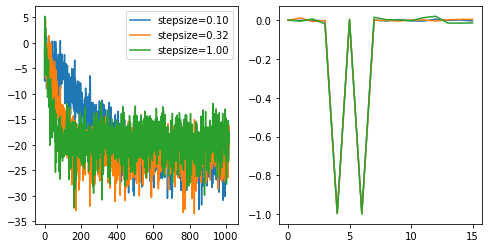

In [3]:
fig, ax = plt.subplots(ncols=2, figsize=(8, 4))
for stepsize in tqdm(stepsizes):
    e = 0
    w = 0
    for i in range(navg):
        # reference signal
        x = np.random.normal(0, 1, len_x)

        # desired signal with noise
        d = olafilt(h_pri, x)
        dn = d + wgn(d, snr, unit="dB")

        filt = LMSFilter(filterlength, stepsize=stepsize)

        y, _, ei, wi = filt(x[len(h_pri):], dn[len(h_pri):])
        
        e += 1/navg * 10 * np.log10(ei**2)
        w += 1/navg * wi
        
    ax[0].plot(e, label=f"stepsize={stepsize:.2f}")
    ax[1].plot(w[-1], label=f"stepsize={stepsize:.2f}")

ax[0].legend()

## LMSFilter with reference

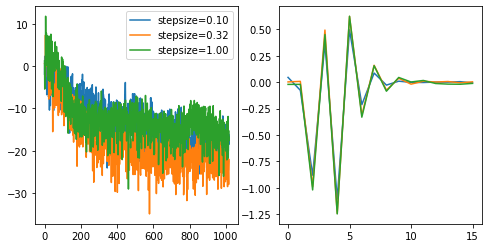

In [4]:
fig, ax = plt.subplots(ncols=2, figsize=(8, 4))
for stepsize in tqdm(stepsizes):
    e = 0
    w = 0
    for i in range(navg):
        # reference signal
        x = np.random.normal(0, 1, len_x)

        # desired signal with noise
        d = olafilt(h_pri, x)
        dn = d + wgn(d, snr, unit="dB")

        filt = LMSFilter(filterlength, stepsize=stepsize)

        y, u, ei, wi = filt(x[len(h_pri):], dn[len(h_pri):], h_sec, h_sec)
        
        e += 1/navg * 10 * np.log10(ei**2)
        w += 1/navg * wi
        
    ax[0].plot(e, label=f"stepsize={stepsize:.2f}")
    ax[1].plot(w[-1], label=f"stepsize={stepsize:.2f}")

ax[0].legend();

## FastBlockLMSFilter

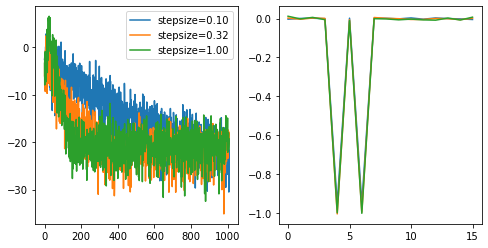

In [5]:
blocklength = filterlength
fig, ax = plt.subplots(ncols=2, figsize=(8, 4))
for stepsize in tqdm(stepsizes):
    e = 0
    w = 0
    for i in range(navg):
        # reference signal
        x = np.random.normal(0, 1, len_x)

        # desired signal with noise
        d = olafilt(h_pri, x)
        dn = d + wgn(d, snr, unit="dB")
        filt = FastBlockLMSFilter(blocklength, filterlength, stepsize=stepsize)
        y, _, ei, wi = filt(x[blocklength:], dn[blocklength:])
        
        e += 1/navg * 10 * np.log10(ei**2)
        w += 1/navg * wi
        
    ax[0].plot(e, label=f"stepsize={stepsize:.2f}")
    ax[1].plot(w[-1], label=f"stepsize={stepsize:.2f}")

ax[0].legend();

## FastBlockLMSFilter with reference

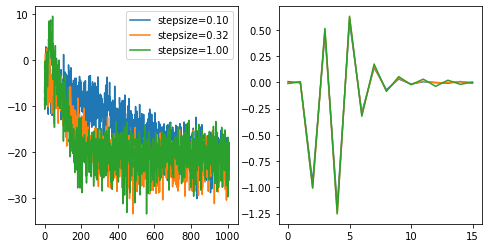

In [6]:
blocklength = filterlength
fig, ax = plt.subplots(ncols=2, figsize=(8, 4))
for stepsize in tqdm(stepsizes):
    e = 0
    w = 0
    for i in range(navg):
        # reference signal
        x = np.random.normal(0, 1, len_x)

        # desired signal with noise
        d = olafilt(h_pri, x)
        dn = d + wgn(d, snr, unit="dB")
        filt = FastBlockLMSFilter(filterlength, blocklength, stepsize=stepsize)
        y, _, ei, wi = filt(x[blocklength:], dn[blocklength:], h_sec, h_sec)
        
        e += 1/navg * 10 * np.log10(ei**2)
        w += 1/navg * wi
        
    ax[0].plot(e, label=f"stepsize={stepsize:.2f}")
    ax[1].plot(w[-1], label=f"stepsize={stepsize:.2f}")

ax[0].legend();

## FakeInterface

In [7]:
from adafilt.io import FakeInterface

buffsize = 16
buffers = 1000
signal = np.random.normal(0, 1, size=buffers * buffsize)
sim = FakeInterface(buffsize, signal, h_pri=h_pri, h_sec=h_sec)

xs = []
es = []
ds = []
us = []
ys = []

for i in range(buffers):
    y = np.random.normal(0, 1, buffsize)
    x, e, u, d = sim.playrec(y, send_signal=True)
    xs.append(x)
    es.append(e)
    ds.append(d)
    us.append(u)
    ys.append(y)

y = np.concatenate(ys)
x = np.concatenate(xs)
e = np.concatenate(es)
u = np.concatenate(us)
d = np.concatenate(ds)

assert np.all(x == signal)
assert np.allclose(d, olafilt(h_pri, x))
assert np.allclose(u, olafilt(h_sec, y))
assert np.allclose(e, u + d)

Measure primary and secondary path

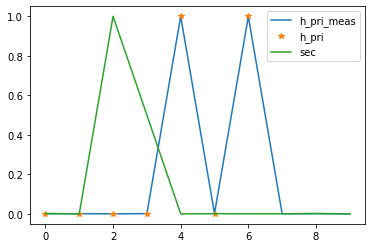

In [8]:
sim = FakeInterface(buffsize, signal, h_pri=h_pri, h_sec=h_sec)

# measure primary path
xs = []
es = []
for i in range(buffers):
    x, e, _, _ = sim.rec()
    xs.append(x)
    es.append(e)
    
xs = np.concatenate(xs)
es = np.concatenate(es)

h_pri_meas = np.fft.irfft(np.fft.rfft(es) / np.fft.rfft(xs))[:10]

# measure secondary path
#sim.reset()
ys = []
us = []
for i in range(buffers):
    y = np.random.normal(0, 1, size=buffsize)
    _, e, _, _ = sim.playrec(y, send_signal=False)
    ys.append(y)
    us.append(e)

ys = np.concatenate(ys)
us = np.concatenate(us)


h_sec_meas = np.fft.irfft(np.fft.rfft(us) / np.fft.rfft(ys))[:10]

plt.plot(h_pri_meas, label="h_pri_meas")
plt.plot(h_pri, "*", label="h_pri")
plt.plot(h_sec_meas, label="sec")
plt.legend()

npt.assert_almost_equal(h_pri_meas[:len(h_pri)], h_pri, decimal=2)
npt.assert_almost_equal(h_sec_meas[:len(h_sec)], h_sec, decimal=2)

## FxLMS

V1 usign adapt and filt

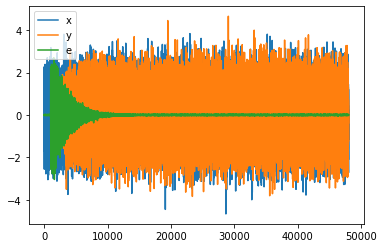

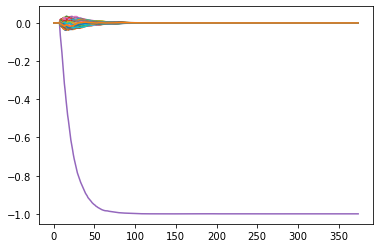

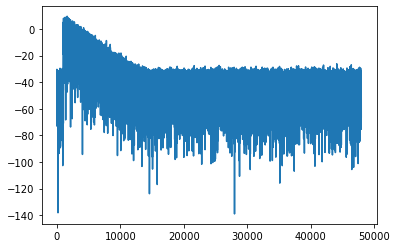

In [9]:
np.set_printoptions(precision=2)
np.random.seed(0)

h_pri = np.zeros(1024)
h_pri[-1] = 1
h_sec = np.zeros(512)
h_sec[-1] = 1

blocklength = 128
length = 512

signal_length = 48000
Nbuffs = signal_length // blocklength

# random signal
signal = np.random.normal(0, 1, size=Nbuffs * blocklength)

filt = LMSFilter(length, stepsize=0.2)
sim = FakeInterface(blocklength, signal, h_pri=h_pri, h_sec=h_sec, noise=wgn(signal, 40, 'dB'))

# error and and filtered reference stepsizest have the same delay 
h_sec_model = np.concatenate((np.zeros(blocklength), h_sec)) 

xlog = []
elog = []
wslog = []
ylog = []

zisec = np.zeros(len(h_sec_model) - 1)
y = np.zeros(blocklength)
for i in tqdm(range(Nbuffs)):
    
    x, e, u, d = sim.playrec(y)
    
    # filtered reference
    fx, zisec = olafilt(h_sec_model, x, zi=zisec)
    
    # work through the single block - sample by sample
    for i in range(blocklength):
        filt.adapt(fx[i], e[i])
        y[i] = filt.filt(x[i])
    
    xlog.append(x)
    elog.append(e)
    ylog.append(y.copy())
    wslog.append(filt.w)
    
xlog = np.concatenate(xlog)
elog = np.concatenate(elog)
ylog = np.concatenate(ylog)

plt.plot(xlog, label="x")
plt.plot(ylog, label="y")
plt.plot(elog, label="e")
plt.legend()

plt.figure()
ax = plt.plot(wslog);
#plt.legend(ax, range(length))

plt.figure()
plt.plot(10*np.log10(np.array(elog)**2))


## FastBlockFxLMS

Some necessary conditions for convergence

In [10]:
assert blocklength <= len(h_sec)
assert blocklength <= len(h_pri) - len(h_sec)
assert length > len(h_pri) - len(h_sec) - blocklength

#### Buffersize == filtersize

In [11]:
700 * 512

358400

/home/fhchl/miniconda3/envs/sfc2/lib/python3.7/site-packages/IPython/core/events.py:88: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  func(*args, **kwargs)
/home/fhchl/miniconda3/envs/sfc2/lib/python3.7/site-packages/IPython/core/pylabtools.py:128: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


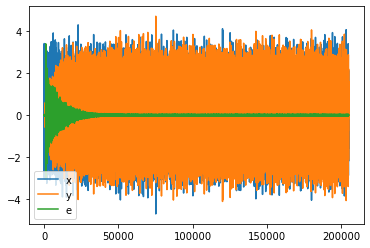

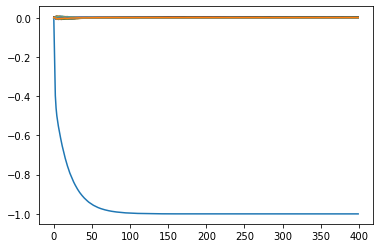

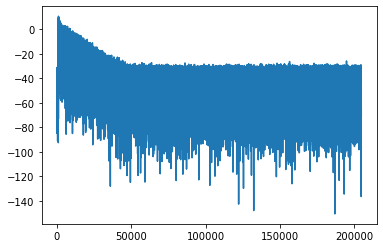

In [12]:
from adafilt import Delay
from adafilt import SimpleFilter
blocklength = 512
length = 512

Nbuffs = 400
signal = np.random.normal(0, 1, size=Nbuffs * blocklength)

filt = FastBlockLMSFilter(blocklength, length, stepsize=0.1)
sim = FakeInterface(blocklength, signal, h_pri=h_pri, h_sec=h_sec, noise=wgn(signal, 40, 'dB'))

# error and and filtered reference stepsizest have the same delay 
h_sec_model = np.concatenate((np.zeros(blocklength), h_sec)) 

sec_model_delay = Delay(blocklength)
sec_model_filter = SimpleFilter(h_sec)

xlog = []
elog = []
wslog = []
ylog = []

zisec = np.zeros(len(h_sec_model) - 1)
y = np.zeros(blocklength)
for i in tqdm(range(Nbuffs)):
    
    x, e, u, d = sim.playrec(y)
    
    # filter reference signal
    fx = sec_model_delay.filt(x)
    fx = sec_model_filter.filt(fx)
        
    # adapt filter
    filt.adapt(fx, e)

    # filter
    y = filt.filt(x)

    xlog.append(x)
    elog.append(e)
    ylog.append(y.copy())
    wslog.append(filt.w)
    
xlog = np.concatenate(xlog)
elog = np.concatenate(elog)
ylog = np.concatenate(ylog)
wslog = np.stack((wslog))

    
plt.plot(xlog, label="x")
plt.plot(ylog, label="y")
plt.plot(elog, label="e")
plt.legend()

plt.figure()
ax = plt.plot(wslog);
#plt.legend(ax, range(length))

plt.figure()
plt.plot(10*np.log10(np.array(elog)**2))


#### Buffersize < filtersize

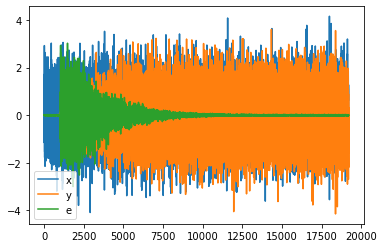

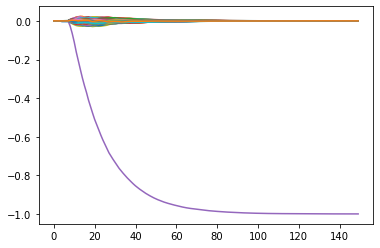

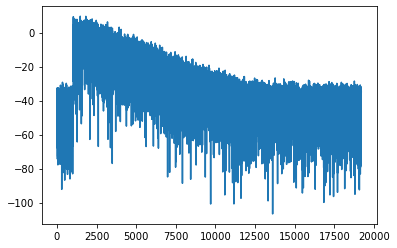

In [13]:
blocklength = 128
length = 512

Nbuffs = 150
signal = np.random.normal(0, 1, size=Nbuffs * blocklength)

filt = FastBlockLMSFilter(length, blocklength)
sim = FakeInterface(blocklength, signal, h_pri=h_pri, h_sec=h_sec, noise=wgn(signal, 40, 'dB'))

# error and and filtered reference stepsizest have the same delay 
h_sec_model = np.concatenate((np.zeros(blocklength), h_sec)) 

xlog = []
elog = []
wslog = []
ylog = []

zisec = np.zeros(len(h_sec_model) - 1)
y = np.zeros(blocklength)
for i in tqdm(range(Nbuffs)):
    
    x, e, u, d = sim.playrec(y)

    fx, zisec = olafilt(h_sec_model, x, zi=zisec)
    
    # adapt filter
    filt.adapt(fx, e)

    # filter
    y = filt.filt(x)

    xlog.append(x)
    elog.append(e)
    ylog.append(y.copy())
    wslog.append(filt.w)
    
xlog = np.concatenate(xlog)
elog = np.concatenate(elog)
ylog = np.concatenate(ylog)
wslog = np.stack((wslog))

    
plt.plot(xlog, label="x")
plt.plot(ylog, label="y")
plt.plot(elog, label="e")
plt.legend()

plt.figure()
ax = plt.plot(wslog);
#plt.legend(ax, range(length))

plt.figure()
plt.plot(10*np.log10(np.array(elog)**2))


# Static Filter

In [14]:
from adafilt.optimal import static_filter

p = np.array([[1, 0, 0, 0],
              [0, 1, 0, 0]]).T
g = np.array([[[1, 0, 0, 0],
               [0, 1, 0, 0]],
              [[1, 0, 0, 0],
               [0, 1, 0, 0]]]).T

np.real(np.fft.ifft(static_filter(p, g, squeeze=True), axis=0))

array([[-0.5, -0.5],
       [ 0. ,  0. ],
       [ 0. ,  0. ],
       [ 0. ,  0. ]])

# Wiener filter

Unconstrained and causal

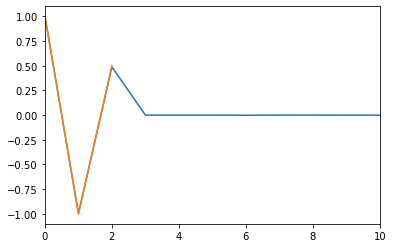

In [15]:
from adafilt.optimal import wiener_filter

h = [1, -1, 0.5]
x = np.random.random(2**14)
y = olafilt(h, x)

h_est = - np.real(np.fft.ifft(wiener_filter(x, y, 32, constrained=False)))
plt.plot(h_est, label="estimate")
plt.plot(h, label="truth")
plt.xlim(0, 10)
npt.assert_almost_equal(h, h_est[:len(h)], decimal=2)

Constrained and causal

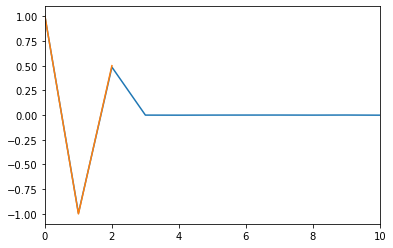

In [16]:
from adafilt.optimal import wiener_filter

h = [1, -1, 0.5]
x = np.random.random(2**14)
y = olafilt(h, x)

h_est = - np.real(np.fft.ifft(wiener_filter(x, y, 32, constrained=True)))
plt.plot(h_est, label="estimate")
plt.plot(h, label="truth")
plt.xlim(0, 10)
npt.assert_almost_equal(h, h_est[:len(h)], decimal=2)

Constrained and non-causal

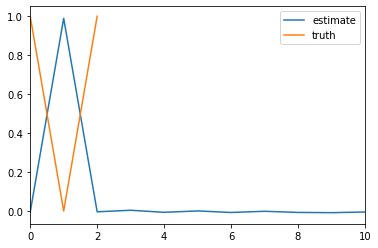

In [17]:
from adafilt.optimal import wiener_filter

h = [1, 0, 1]
x = np.random.random(2**16)
y = olafilt(h, x)

h_est = - np.real(np.fft.ifft(wiener_filter(x, y, 256, g=[0, 1], constrained=True)))
plt.plot(h_est, label="estimate")
plt.plot(h, label="truth")
plt.xlim(0, 10)
plt.legend()
npt.assert_almost_equal([0, 1, 0], h_est[:len(h)], decimal=2)

# Multichannel Wiener Filter

Single channel

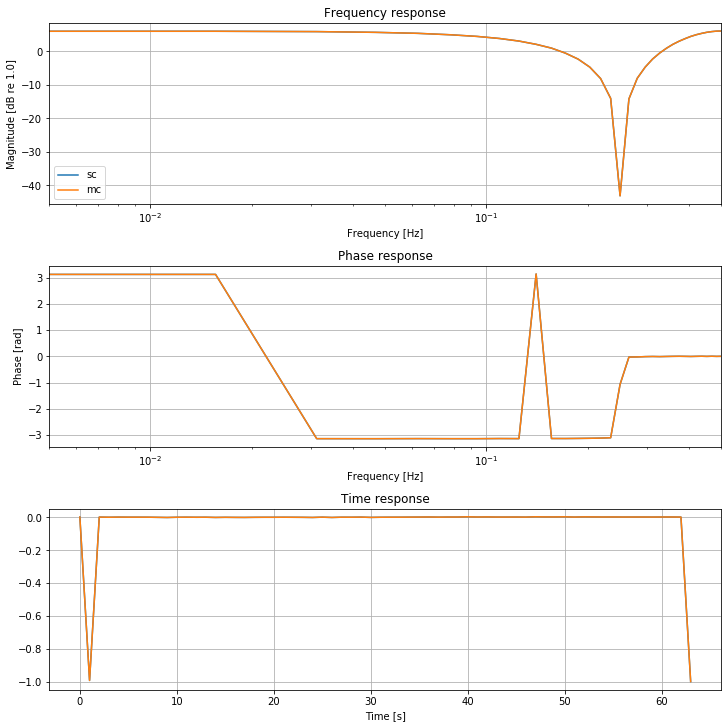

In [18]:
from adafilt.optimal import multi_channel_wiener_filter
from response import Response

n = 16
p = [1, 0, 1]
g = [0, 1, 0]
x = np.random.random(2**14)
d = olafilt(p, x)

nfilt = n * 4
wopt = wiener_filter(x, d, nfilt, g)
woptmc = multi_channel_wiener_filter(x, d, nfilt, g)

fig = Response.from_freq(1, wopt[:nfilt // 2 + 1]).plot(label="sc")
Response.from_freq(1, woptmc[:nfilt // 2 + 1].T).plot(use_fig=fig, label="mc");

npt.assert_almost_equal(wopt, woptmc[:, 0, 0])

Multichannel

/home/fhchl/Dropbox/Software/response/response.py:367: RuntimeWarning: divide by zero encountered in log10
  20 * np.log10(np.abs(freq_plotready / dbref)),


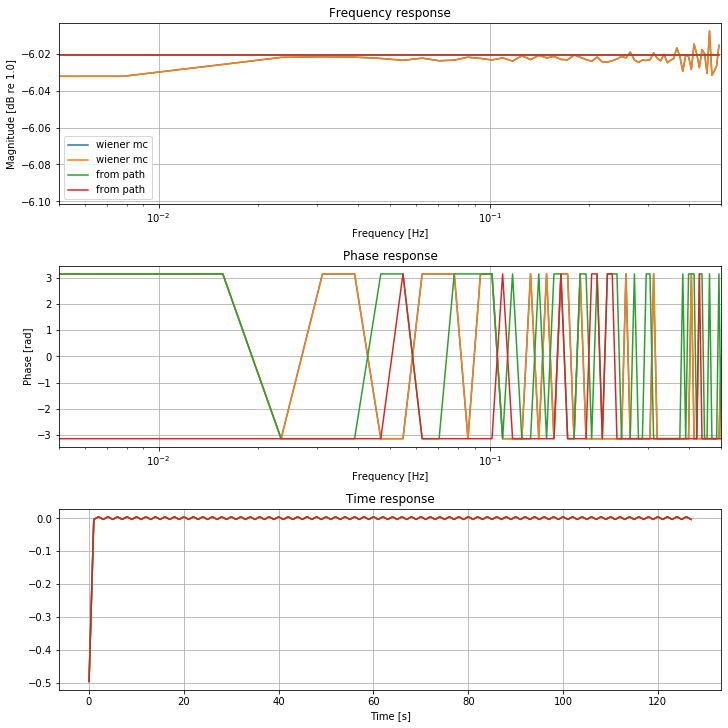

In [20]:
n = 32
Nin = 1
Nout = 2
Nmic = 3

# primary path
p = np.zeros((n, Nmic))
p[[1, 0, 1]] = 1

# secondary path
g = np.zeros((n, Nmic, Nout))
g[[0, 1]] = 1

# signal
x = np.random.normal(size=(2**18, Nin))
d = olafilt(p, x, 'nl,nk->nl')

nfilt = 4 * n
Wsig = multi_channel_wiener_filter(x, d, nfilt, g)
Wpath = static_filter(p, g, nfilt)

fig = Response.from_freq(1, Wsig[:nfilt // 2 + 1].T).plot(label="wiener mc");
Response.from_freq(1, Wpath[:nfilt // 2 + 1].T).plot(use_fig=fig, label="from path");

# MultichannelBlockLMS

FAILS: Compare to single channel 

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


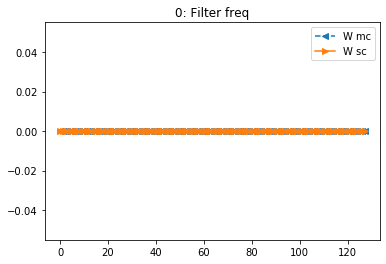

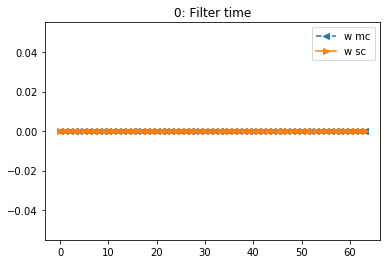

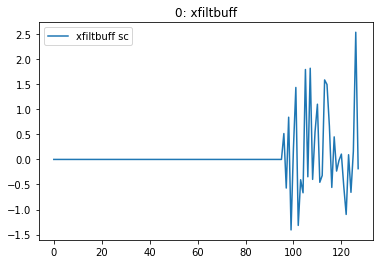

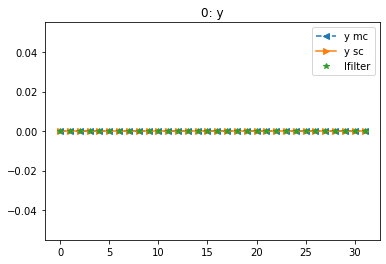

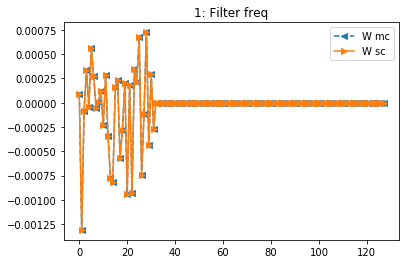

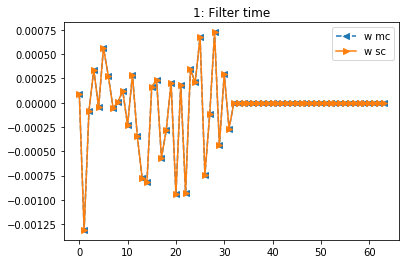

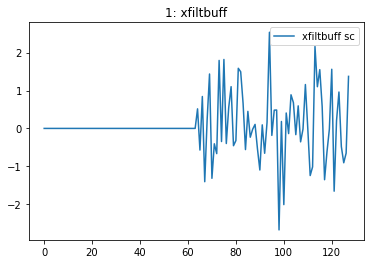

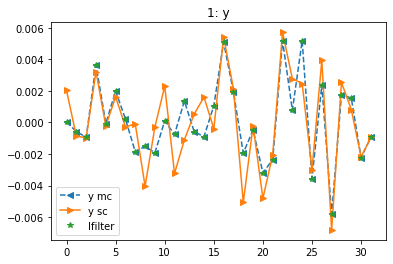

AssertionError: 
Arrays are not almost equal to 6 decimals

Mismatch: 96.9%
Max absolute difference: 0.00312774
Max relative difference: 18.68638375
 x: array([ 4.576242e-05, -5.847286e-04, -9.305466e-04,  3.645967e-03,
       -6.457799e-05,  1.998166e-03,  2.236703e-04, -1.868301e-03,
       -1.513219e-03, -1.923205e-03,  1.003822e-04, -7.586383e-04,...
 y: array([ 2.029867e-03, -8.678920e-04, -9.664603e-04,  3.233792e-03,
       -2.177209e-04,  1.630767e-03, -2.734965e-04, -9.490319e-05,
       -4.036410e-03, -2.878648e-04,  2.306909e-03, -3.231476e-03,...

In [2]:
%load_ext autoreload
%autoreload 2

import numpy as np
import matplotlib.pyplot as plt
from adafilt import MultiChannelBlockLMS, Delay, SimpleFilter, FastBlockLMSFilter
from adafilt.io import FakeInterface
from adafilt.utils import wgn
import numpy.testing as npt
from tqdm import tqdm_notebook as tqdm
from scipy.signal import lfilter
import warnings

warnings.filterwarnings(action="error", category=np.ComplexWarning)

Nin = 1
Nout = 1
Nsens = 1

# signal
nsignal = 4800
blocklength = 32
Nbuffs = nsignal // blocklength
signal = np.random.normal(0, 1, size=(Nbuffs * blocklength, Nin))

# paths
n = 64
h_pri = np.zeros((n, Nsens, Nin))
h_pri[-1] = 1
h_sec = np.zeros((n, Nsens, Nout))
h_sec[0] = 1

# init filters
length = 64
sec_model_delay = Delay(blocklength)
sec_model_delaysc = Delay(blocklength)
sec_model_filter = SimpleFilter(h_sec, 'nlm,nk->nlmk')
sec_model_filtersc = SimpleFilter(h_sec[:, 0, 0])

winit = np.zeros((length, Nout, Nin))

filt = MultiChannelBlockLMS(
    length=length, blocklength=blocklength, stepsize=0.001, constrained=True, initial_coeff=winit
)
filtsc = FastBlockLMSFilter(
    length=length, blocklength=blocklength, stepsize=0.001, constrained=True, initial_coeff=winit[:, 0, 0], normalized=False
)

# init sim
sim = FakeInterface(blocklength, signal, h_pri=h_pri, h_sec=h_sec)

# aggregate signals during simulation
xlog = []
elog = []
wslog = []
ylog = []

zilf = np.zeros(max(len(filtsc.w), blocklength) - 1)
y = np.zeros((blocklength, Nout))  # control signal is zero for first block
for i in tqdm(range(6)):
    
    x, e, u, d = sim.playrec(y)
    xc = x.copy()
    ec = e.copy()
    
    # filter reference signal
    fxsc = sec_model_delaysc.filt(x[:, 0])
    fxsc = sec_model_filtersc.filt(fxsc)
    fx = sec_model_delay.filt(x)
    fx = sec_model_filter.filt(fx)
    
    npt.assert_array_almost_equal(fx[:, 0, 0, 0], fxsc)
    
    npt.assert_equal(xc, x)
    npt.assert_equal(ec, e)
        
    filtsc.adapt(fxsc, e[:, 0])
    filt.adapt(fx, e)
    
    npt.assert_array_almost_equal(filt.w[:, 0, 0], filtsc.w)
    npt.assert_array_almost_equal(filt.W[:, 0, 0], filtsc.W)
    
    plt.figure(4)
    plt.title(f"{i}: Filter freq")
    plt.plot(np.real(np.fft.ifft(filt.W[:, 0, 0], axis=0)), "<--", label="W mc")
    plt.plot(np.real(np.fft.ifft(filtsc.W, axis=0)), ">-", label="W sc")
    plt.legend()
    
    plt.figure(5)
    plt.title(f"{i}: Filter time")
    plt.plot(filt.w[:, 0, 0], "<--", label="w mc")
    plt.plot(filtsc.w, ">-", label="w sc")
    plt.legend()
    
    npt.assert_equal(xc, x)
    npt.assert_equal(ec, e)
    
    # filter
    ysc = filtsc.filt(x[:, 0])
    y = filt.filt(x)
    plt.figure(0)
    plt.title(f"{i}: xfiltbuff")
    plt.plot(filtsc.xfiltbuff, label='xfiltbuff sc')
    plt.legend()
    
    npt.assert_equal(xc, x)
    npt.assert_equal(ec, e)
    
    ylf, zilf = lfilter(filtsc.w, 1, x[:, 0], zi=zilf)
    plt.figure(6)
    plt.title(f"{i}: y")
    plt.plot(y[:, 0], "<--", label="y mc")
    plt.plot(ysc, ">-", label="y sc")
    plt.plot(ylf, "*", label="lfilter")
    plt.legend()

    plt.show()
    
    npt.assert_array_almost_equal(y[:, 0], ysc)
    npt.assert_equal(xc, x)
    npt.assert_equal(ec, e)
    
#     xlog.append(x[:, 0])
#     elog.append(e[:, 0])
#     ylog.append(ysc)
#     wslog.append(filtsc.w.copy())
    
# plt.title("Final filter")
# plt.plot(filtsc.w)
# plt.xlabel("Tap")

# plt.figure()
# plt.title("signal")
# plt.plot(np.concatenate(xlog))

# plt.figure()
# plt.title("Error Energy")
# plt.plot(10 * np.log10(np.array(np.concatenate(elog)) ** 2))
# plt.xlabel("Sample")
# plt.ylabel("Error [dB]")

# plt.figure()
# plt.title("output")
# plt.plot(np.concatenate(ylog))
# plt.xlabel("Sample");

0


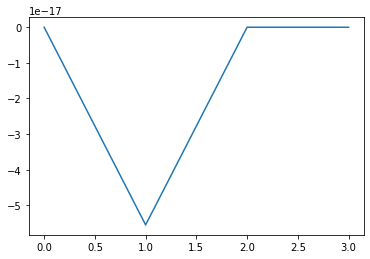

1


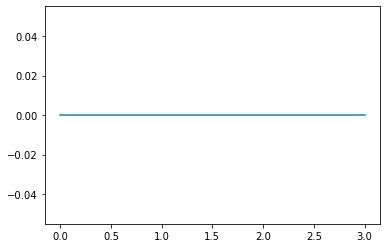

AssertionError: 
Arrays are not almost equal to 7 decimals

Mismatch: 100%
Max absolute difference: 0.001066
Max relative difference: 0.0013243
 x: array([-1.6121463, -0.8060211])
 y: array([-1.612693 , -0.8049551])

In [6]:
length = 4
blocks = 6
blocklength = 2
w = np.ones((length, 1, 1))

filtsc = FastBlockLMSFilter(
    length=length, blocklength=blocklength, stepsize=0.001, constrained=True, initial_coeff=w[:, 0, 0], normalized=False
)
filtmc = MultiChannelBlockLMS(
    length=length, blocklength=blocklength, stepsize=0.001, constrained=True, initial_coeff=w
)

xs = np.random.normal(size=(blocks, blocklength, 1))

ysc = []
ymc = []
i = 0

plt.figure(1)
for xb in xs:
    print(i)
    i+=1
    filtsc.adapt(xb[:, 0], xb[:, 0] * 2)
    filtmc.adapt(xb[:, None, None], xb * 2)

    # toggling between these makes problem, but filters in mc and sc shouyld be the same in any case
#     Wnew = np.fft.fft(w, axis=0, n=2 * length).copy()
    Wnew = filtsc.W[:, None, None].copy()
    
    plt.plot(np.real(np.fft.ifft(Wnew[:, 0, 0]))[4:])
    plt.show()

    filtsc.W = Wnew[:, 0, 0]
    filtmc.W = Wnew

    ysc = filtsc.filt(xb[:, 0])
    npt.assert_array_almost_equal(filtmc.W[:, 0, 0], filtsc.W)
    ymc = filtmc.filt(xb)
    npt.assert_array_almost_equal(filtmc.W[:, 0, 0], filtsc.W)
    
    npt.assert_almost_equal(ysc, ymc[:, 0])

It does converge, however

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


/home/fhchl/miniconda3/envs/sfc2/lib/python3.7/site-packages/ipykernel_launcher.py:75: RuntimeWarning: divide by zero encountered in log10


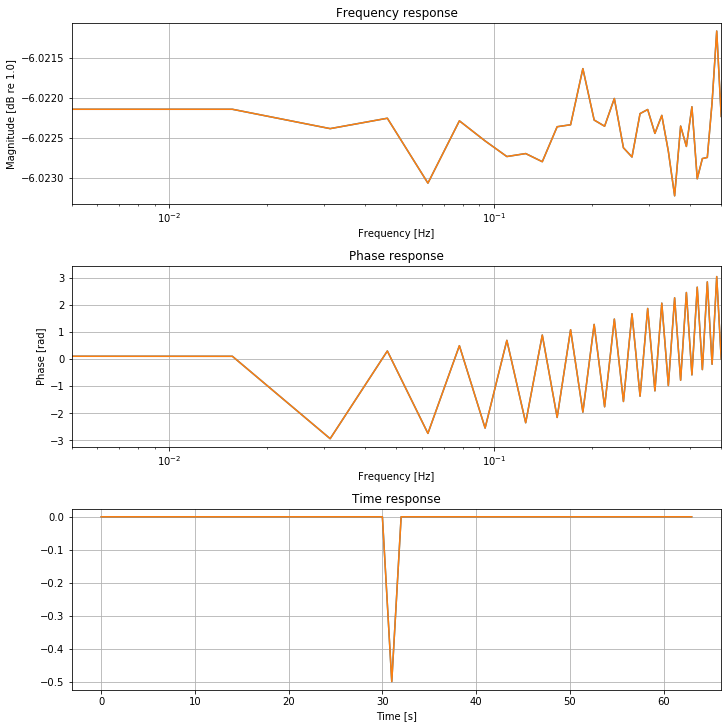

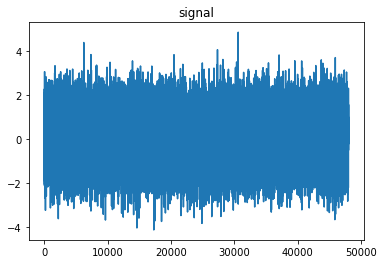

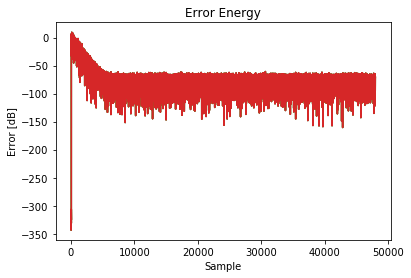

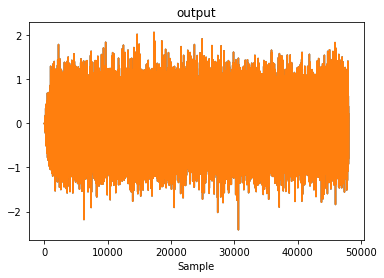

In [4]:
%load_ext autoreload
%autoreload 2

import numpy as np
import matplotlib.pyplot as plt
from adafilt import MultiChannelBlockLMS, Delay, SimpleFilter, FastBlockLMSFilter
from adafilt.io import FakeInterface
from adafilt.utils import wgn
import numpy.testing as npt
from tqdm import tqdm_notebook as tqdm
from scipy.signal import lfilter
import warnings
from response import Response

warnings.filterwarnings(action="error", category=np.ComplexWarning)

Nin = 1
Nout = 2
Nsens = 4

# signal
nsignal = 48000
blocklength = 32
Nbuffs = nsignal // blocklength
signal = np.random.normal(0, 1, size=(Nbuffs * blocklength, Nin))

# paths
n = 64
h_pri = np.zeros((n, Nsens, Nin))
h_pri[-1] = 1
h_sec = np.zeros((n, Nsens, Nout))
h_sec[0] = 1

# init filters
length = 64
filt = MultiChannelBlockLMS(Nin=Nin, Nout=Nout, Nsens=Nsens, length=length, blocklength=blocklength, leakage=0.99999, stepsize=0.0001, constrained=True)
sec_model_delay = Delay(blocklength)
sec_model_filter = SimpleFilter(h_sec, 'nlm,nk->nlmk')

# init sim
sim = FakeInterface(blocklength, signal, h_pri=h_pri, h_sec=h_sec)

# aggregate signals during simulation
xlog = []
elog = []
wslog = []
ylog = []

y = np.zeros((blocklength, Nout))  # control signal is zero for first block
for i in tqdm(range(Nbuffs)):
    
    x, e, u, d = sim.playrec(y)
    
    # filter reference signal
    fx = sec_model_delay.filt(x)
    fx = sec_model_filter.filt(fx)
    filt.adapt(fx, e)
    
    # filter
    y = filt.filt(x)

    xlog.append(x)
    elog.append(e)
    ylog.append(y)
    wslog.append(filt.w.copy())

Response.from_time(1, filt.w.T).plot()

plt.figure()
plt.title("signal")
plt.plot(np.concatenate(xlog))

plt.figure()
plt.title("Error Energy")
plt.plot(10 * np.log10(np.array(np.concatenate(elog)) ** 2))
plt.xlabel("Sample")
plt.ylabel("Error [dB]")

plt.figure()
plt.title("output")
plt.plot(np.concatenate(ylog))
plt.xlabel("Sample");